In [1]:
  pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-st8no5xl
  Running command git clone -q https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-st8no5xl
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3.2-cp36-none-any.whl size=3881 sha256=7a31562d8968c9bf58b2b999e607c01a87d44fcae0ba4a0ab1b9ffdb4cd9c4db
  Stored in directory: /tmp/pip-ephem-wheel-cache-j959nyms/wheels/b7/24/83/d30234cc013cff538805b14df916e79091f7cf9ee2c5bf3a64
Successfully built warmup-scheduler


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets

import numpy as np

import os

import time

### Step 1. Construct a CNN model

#### Implementation 1-1. Design SimCLRHead class

#### Implementation 1-2. Design SimCLRNet class

In [3]:
import math
from torchvision.models.resnet import conv3x3

class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, norm_layer, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.downsample = downsample
        self.stride = stride
        
        self.bn1 = norm_layer(inplanes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = conv3x3(inplanes, planes, stride)
        
        self.bn2 = norm_layer(planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)

    def forward(self, x):
        residual = x 
        residual = self.bn1(residual)
        residual = self.relu1(residual)
        residual = self.conv1(residual)

        residual = self.bn2(residual)
        residual = self.relu2(residual)
        residual = self.conv2(residual)

        if self.downsample is not None:
            x = self.downsample(x)
        return x + residual

class Downsample(nn.Module):
    def __init__(self, nIn, nOut, stride):
        super(Downsample, self).__init__()
        self.avg = nn.AvgPool2d(stride)
        assert nOut % nIn == 0
        self.expand_ratio = nOut // nIn

    def forward(self, x):
        x = self.avg(x)
        return torch.cat([x] + [x.mul(0)] * (self.expand_ratio - 1), 1)

class ResNetCifar(nn.Module):
    def __init__(self, depth, width=1, classes=10, channels=3, norm_layer=nn.BatchNorm2d):
        assert (depth - 2) % 6 == 0         # depth is 6N+2
        self.N = (depth - 2) // 6
        super(ResNetCifar, self).__init__()

        # Following the Wide ResNet convention, we fix the very first convolution
        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.inplanes = 16
        self.layer1 = self._make_layer(norm_layer, 16 * width)
        self.layer2 = self._make_layer(norm_layer, 32 * width, stride=2)
        self.layer3 = self._make_layer(norm_layer, 64 * width, stride=2)
        self.bn = norm_layer(64 * width)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(8)

        # Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                
    def _make_layer(self, norm_layer, planes, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = Downsample(self.inplanes, planes, stride)
        layers = [BasicBlock(self.inplanes, planes, norm_layer, stride, downsample)]
        self.inplanes = planes
        for i in range(self.N - 1):
            layers.append(BasicBlock(self.inplanes, planes, norm_layer))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

    
class Normalize(nn.Module):

    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power

    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1. / self.power)
        out = x.div(norm)
        return out
    

class SimCLRHead(nn.Module):
    def __init__(self, width, emb_dim):
        super(SimCLRHead, self).__init__()
        
        ### IMPLEMENTATION 1-1 ###
        ### 1. Linear layer (64 * width -> 64 * width)
        ### 2. ReLU
        ### 3. Linear layer (64 * width -> emb_dim)
        ### 4. Normalization layer (Normalize module above)
        self.fc1 = nn.Linear(64 * width, 64 * width)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(64 * width, emb_dim)
        self.norm = Normalize()
        ### IMPLEMENTATION ENDS HERE ###
        
    def forward(self, x):
        
        ### IMPLEMENTATION 1-1 ###
        ### Design a proper forward function
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.norm(x)

        ### IMPLEMENTATION ENDS HERE ###
        return x
    

class SimCLRNet(nn.Module):
    def __init__(self, depth, width=1, num_classes=10, emb_dim=32):
        super(SimCLRNet, self).__init__()
        
        self.num_classes = num_classes
        
        self.feat = ResNetCifar(depth=depth, width=width, classes=num_classes)
        
        ### IMPLEMENTATION 1-2 ###
        ### 1. A projection head (SimCLRHead module above)
        self.head = SimCLRHead(width, emb_dim)
        
        ### 2. A linear classifier (64 * width -> num_classes)
        self.classifier = nn.Linear(64 * width, num_classes)
        
        ### 3. Normalization layer for conv feature normalization (Normalize module above)
        self.norm = Normalize()
        
        ### IMPLEMENTATION ENDS HERE ###
    
    def forward(self, x, norm_feat=False):
        
        ### IMPLEMENTATION 1-2 ###
        ### Your module must return
        ### 1. Conv feature (feat) - when norm_feat is true, apply L2 normalization
        ### 2. Projected embedding (emb)
        ### 3. Logit vector by the linear classifier (logit)
        
        feat = self.feat(x)
        if norm_feat :
          feat = self.norm(feat)
        
        emb = self.head(feat)
        logit = self.classifier(feat)

        ### IMPLEMENTATION ENDS HERE ###
        return feat, emb, logit

### Step 2. Prepare datasets & data augmentations

For contrastaive learning, a set of random augmentation functions is first defined.

Then, the set is applied twice to each image, which is implemented as provided DuplicatedCompose module

#### Implementation 2-1. Design a train transform (train_transform)

Follow the instruction inside the train_transform

https://pytorch.org/docs/stable/torchvision/transforms.html

Refer to the torchvision.transforms documentation

In [4]:
class DuplicatedCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        img1 = img.copy()
        img2 = img.copy()
        for t in self.transforms:
            img1 = t(img1)
            img2 = t(img2)
        return img1, img2

In [5]:
import cv2
cv2.setNumThreads(0)

class GaussianBlur(object):
    # Implements Gaussian blur as described in the SimCLR paper
    def __init__(self, kernel_size, min=0.1, max=2.0):
        self.min = min
        self.max = max
        # kernel size is set to be 10% of the image height/width
        self.kernel_size = kernel_size
        
        if self.kernel_size % 2 == 0:
            self.kernel_size += 1

    def __call__(self, sample):
        sample = np.array(sample)

        # blur the image with a 50% chance
        prob = np.random.random_sample()

        if prob < 0.5:
            sigma = (self.max - self.min) * np.random.random_sample() + self.min
            sample = cv2.GaussianBlur(sample, (self.kernel_size, self.kernel_size), sigma)

        return sample

In [6]:
import torchvision.transforms as transforms

img_size = (32, 32)

color_jitter = transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)

train_transform = DuplicatedCompose([
    ### IMPLEMENTATION 2-1 ###
    ### 1. Random resized crop w/ final size of (32, 32)
    ### 2. Random horizontal flip w/ p=0.5
    ### 3. Randomly apply the pre-defined color jittering w/ p=0.8
    ### 4. Random gray scale w/ p=0.2
    ### 5. Gaussian blur w/ kernel size of 1/10 of the image width or height (32)
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    color_jitter,
    transforms.RandomGrayscale(p=0.2),
    GaussianBlur(img_size[0]//10),
    
    ### IMPLEMENTATION ENDS HERE ###
    transforms.ToTensor(),
])

In [7]:
from torch.utils.data import DataLoader

train_dataset = datasets.CIFAR10(root='.',
                                 train=True,
                                 download=True,
                                 transform=train_transform
                                )

train_loader = DataLoader(train_dataset,
                          batch_size=256,
                          num_workers=4,
                          shuffle=True,
                          drop_last=True
                         )

Extracting ./cifar-10-python.tar.gz to .


### Step 3. Implement InfoNCE loss

In [8]:
class NTXentLoss(torch.nn.Module):

    def __init__(self, batch_size, temperature, use_cosine_similarity):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.softmax = torch.nn.Softmax(dim=-1)
        self.mask_samples_from_same_repr = self._get_correlated_mask().type(torch.bool)
        self.similarity_function = self._get_similarity_function(use_cosine_similarity)
        self.criterion = torch.nn.CrossEntropyLoss(reduction="sum")

    def _get_similarity_function(self, use_cosine_similarity):
        if use_cosine_similarity:
            self._cosine_similarity = torch.nn.CosineSimilarity(dim=-1)
            return self._cosine_simililarity
        else:
            return self._dot_simililarity

    def _get_correlated_mask(self):
        diag = np.eye(2 * self.batch_size)
        l1 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=-self.batch_size)
        l2 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=self.batch_size)
        mask = torch.from_numpy((diag + l1 + l2))
        mask = (1 - mask).type(torch.bool)
        return mask.cuda()

    @staticmethod
    def _dot_simililarity(x, y):
        v = torch.tensordot(x.unsqueeze(1), y.T.unsqueeze(0), dims=2)
        # x shape: (N, 1, C)
        # y shape: (1, C, 2N)
        # v shape: (N, 2N)
        return v

    def _cosine_simililarity(self, x, y):
        # x shape: (N, 1, C)
        # y shape: (1, 2N, C)
        # v shape: (N, 2N)
        v = self._cosine_similarity(x.unsqueeze(1), y.unsqueeze(0))
        return v

    def forward(self, zis, zjs):
        representations = torch.cat([zjs, zis], dim=0)

        similarity_matrix = self.similarity_function(representations, representations)

        # filter out the scores from the positive samples
        l_pos = torch.diag(similarity_matrix, self.batch_size)
        r_pos = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([l_pos, r_pos]).view(2 * self.batch_size, 1)

        negatives = similarity_matrix[self.mask_samples_from_same_repr].view(2 * self.batch_size, -1)

        logits = torch.cat((positives, negatives), dim=1)
        logits = logits / self.temperature

        labels = torch.zeros(2 * self.batch_size).cuda().long()
        loss = self.criterion(logits, labels)

        return loss / (2 * self.batch_size)

### Step 4. Run pre-training step

#### Implementation 4-1. Complete a basic SimCLR training loop

https://github.com/ildoonet/pytorch-gradual-warmup-lr

The linear warmup scheduler implementation is from a github in the link above

https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Refer to this documentation to use lr schedulers integrated in PyTorch

In [9]:
from torch.optim.optimizer import Optimizer, required

class SGD_with_lars(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).
    """

    def __init__(self, params, lr=required, momentum=0, weight_decay=0, trust_coef=1.): # need to add trust coef
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if trust_coef < 0.0:
            raise ValueError("Invalid trust_coef value: {}".format(trust_coef))

        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, trust_coef=trust_coef)

        super(SGD_with_lars, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD_with_lars, self).__setstate__(state)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            trust_coef = group['trust_coef']
            global_lr = group['lr']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                p_norm = torch.norm(p.data, p=2)
                d_p_norm = torch.norm(d_p, p=2).add_(momentum, p_norm)
                lr = torch.div(p_norm, d_p_norm).mul_(trust_coef)

                lr.mul_(global_lr)

                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)

                d_p.mul_(lr)

                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(d_p)
                    d_p = buf

                p.data.add_(-1, d_p)

        return loss

In [10]:
def train(net, loader):
    
    batch_size=256
    temperature=0.07

    loss_fn = NTXentLoss(batch_size=batch_size, temperature=temperature, use_cosine_similarity=True)
    
    ### IMPLEMENTATION 4-2 ###
    ### 1. Use SGD_with_lars with
    ### lr = 0.1 * batch_size / 256
    ### momentum = 0.9
    ### weight_decay = 1e-6
    optimizer = SGD_with_lars(net.parameters(), lr = 0.1 * batch_size / 256, momentum=0.9, weight_decay=1e-6)
    
    from warmup_scheduler import GradualWarmupScheduler
    ### 2. Use GradualWarmupScheduler with
    ### multiplier = 1
    ### total_epoch = 1/10 of total epochs
    ### after_scheduler = optim.lr_scheduler.CosineAnnealingLR
    scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=20, 
                                       after_scheduler=optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=180))
    
    train_start = time.time()
    
    loss_hist = []

    for epoch in range(1, 200 + 1):
        
        train_loss = 0
        net.train()
        
        epoch_start = time.time()
        for idx, (data, target) in enumerate(loader):
            optimizer.zero_grad()
            
            ### 3. data variable contains two augmented images
            ### -1. send them to your GPU by calling .cuda()
            ### -2. forward each of them to net
            ### -3. compute the InfoNCE loss
            
            # target : labels.

            zi, zj = data
            
            feat_i, emb_i, logit_i = net(zi.cuda())
            feat_j, emb_j, logit_j = net(zj.cuda())
            loss = loss_fn(emb_i, emb_j)

            ### IMPLEMENTATION ENDS HERE ###
            
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        train_loss /= (idx + 1)
        loss_hist.append(train_loss) # added by junwon
        scheduler.step()
        
        epoch_time = time.time() - epoch_start
        print("Epoch\t", epoch, 
              "\tLoss\t", train_loss, 
              "\tTime\t", epoch_time,
             )
        
    elapsed_train_time = time.time() - train_start
    print('Finished training. Train time was:', elapsed_train_time)

    return loss_hist



In [11]:
GPU_NUM = '0'
os.environ["CUDA_VISIBLE_DEVICES"] = GPU_NUM

net = SimCLRNet(26, 1, 10, 32)

net.cuda()

SimCLRNet(
  (feat): ResNetCifar(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(i

In [ ]:
#net.zero_grad()
loss_list = train(net, train_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


Epoch	 1 	Loss	 6.267516270661965 	Time	 68.65935754776001
Epoch	 2 	Loss	 5.997548533708621 	Time	 69.4774341583252
Epoch	 3 	Loss	 5.726462474236121 	Time	 69.28733396530151
Epoch	 4 	Loss	 5.385201908991887 	Time	 69.1840991973877
Epoch	 5 	Loss	 5.067203159821339 	Time	 69.04848051071167
Epoch	 6 	Loss	 4.6063751465235 	Time	 69.27956533432007
Epoch	 7 	Loss	 4.163073110580444 	Time	 69.10657048225403
Epoch	 8 	Loss	 3.8278773857997015 	Time	 69.57406044006348
Epoch	 9 	Loss	 3.618078660964966 	Time	 69.37399625778198
Epoch	 10 	Loss	 3.4667221289414627 	Time	 69.22460794448853
Epoch	 11 	Loss	 3.326366952749399 	Time	 69.36655616760254
Epoch	 12 	Loss	 3.212576044522799 	Time	 68.8926649093628
Epoch	 13 	Loss	 3.1059215570107486 	Time	 69.45085096359253
Epoch	 14 	Loss	 3.0056425815973524 	Time	 69.58503246307373
Epoch	 15 	Loss	 2.9502402220016872 	Time	 69.60094261169434
Epoch	 16 	Loss	 2.8980539407485573 	Time	 69.69247913360596
Epoch	 17 	Loss	 2.8292446454366047 	Time	 69.91

In [12]:
import matplotlib.pyplot as plt

def plot_loss(loss_hist, xlabel='Iteration number', ylabel='Loss value') :
  plt.plot(loss_hist)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

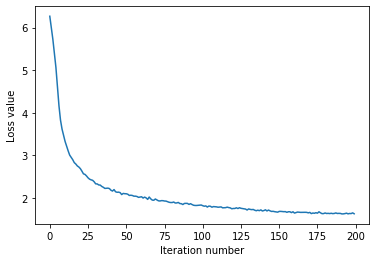

In [ ]:
plot_loss(loss_list)

In [13]:
def save_model(model, model_save_name = 'SIMCLR.pt' ) :
  # save ckpt in google drive.
  from google.colab import drive
  drive.mount('/content/gdrive')
  path = F"/content/gdrive/My Drive/{model_save_name}" 
  torch.save(model.state_dict(), path)

In [14]:
def load_model(model, path='SIMCLR.pt') :
  from google.colab import drive
  drive.mount('/content/gdrive')
  checkpoints_folder =  F"/content/gdrive/My Drive/{path}" 
  state_dict = torch.load(checkpoints_folder)
  model.load_state_dict(state_dict)

In [15]:
save_model(net, "simclr_new.pt")

Mounted at /content/gdrive


In [15]:
load_model(net, "simclr_new.pt")

Mounted at /content/gdrive


## Linear Evaluation Protocol

- train Linear classifier with freezed extractor f

In [16]:
def train_classifier(net, loader):
    
    batch_size=256
    temperature=0.07

    loss_fn = torch.nn.CrossEntropyLoss()

    # Freezing
    net.feat.requires_grad = False
    net.head.requires_grad = False
    net.norm.requires_grad = False

   # net.feat.train(False)
  
    optimizer = torch.optim.Adam(net.classifier.parameters(), lr=1e-3)
    
    train_start = time.time()
    
    loss_hist = []
    min_loss = 10000

    for epoch in range(1, 10 + 1):
        
        train_loss = 0
        #net.feat.train(False)
        #net.classifier.train(True) 
        net.train()
        epoch_start = time.time()

        for idx, (data, target) in enumerate(loader):
            optimizer.zero_grad()
            
            feat, emb, logit = net(data.cuda())
            
            loss = loss_fn(logit, target.cuda())
          
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        train_loss /= (idx + 1)
        loss_hist.append(train_loss) # added by junwon
        if train_loss < min_loss :
          min_loss = train_loss
          save_model(net, "classifier")
       
        epoch_time = time.time() - epoch_start
        print("Epoch\t", epoch, 
              "\tLoss\t", train_loss, 
              "\tTime\t", epoch_time,
             )
        
    elapsed_train_time = time.time() - train_start
    print('Finished training. Train time was:', elapsed_train_time)

    return loss_hist

def test_classifier(net, loader) :
  
  net.eval()
  
  correct = 0
  total = 0
  
  with torch.no_grad() :
    for idx, (data, target) in enumerate(loader):
      
      feat, emb, logit = net(data.cuda())
      #loss = loss_fn(logit, target.cuda())
      
      _, class_i = torch.max(logit.data, 1)

      correct += (class_i == target.cuda()).sum().item()  
      total += target.size(0)

    accuracy = correct / total
    print('Accuracy : %d %%' % (100 * accuracy))
  
  return accuracy
  


In [17]:
from torch.utils.data import DataLoader

linear_dataset = datasets.CIFAR10(root='.',
                                 train=True,
                                 download=True,
                                 transform=transforms.ToTensor()
                                )

linear_loader = DataLoader(linear_dataset,
                          batch_size=256,
                          num_workers=4,
                          shuffle=True,
                          drop_last=True
                         )

test_dataset = datasets.CIFAR10(root='.',
                                 train=False,
                                 download=True,
                                 transform=transforms.ToTensor()
                                )

test_loader = DataLoader(test_dataset,
                          batch_size=256,
                          num_workers=4,
                          shuffle=True,
                          drop_last=True
                         )

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
loss_list = train_classifier(net, linear_loader)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Epoch	 1 	Loss	 2.03468404121888 	Time	 17.137782096862793
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Epoch	 2 	Loss	 1.6301073435025337 	Time	 17.24441909790039
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Epoch	 3 	Loss	 1.4283286290291028 	Time	 17.066750288009644
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Epoch	 4 	Loss	 1.3150144711518899 	Time	 17.026099681854248
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Epoch	 5 	Loss	 1.2440750293242626 	Time	 17.067901849746704
Drive already mounted at /content/gdrive; t

In [ ]:
acc = test_classifier(net, test_loader)

Accuracy : 64 %


## classifier를 Train할 때 Epoch
계속 Loss 낮아지지만, 이미 60%를 넘으므로. 
Pretrain 성능을 평가하기 위해 
"초기에 얼마나 트레인이 잘 되는지" 를 평가하기 위해서 에폭을 늘리지 않음. 

##Train Function with Parameters.

- save the model with lowest loss
- parameters : batch_size, temparture, pre-training epochs.



In [18]:
from torch.utils.data import DataLoader

def make_loader(batch_size) :
  
  train_dataset = datasets.CIFAR10(root='.',
                                  train=True,
                                  download=True,
                                  transform=train_transform
                                  )

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            num_workers=4,
                            shuffle=True,
                            drop_last=True
                          )
  
  linear_dataset = datasets.CIFAR10(root='.',
                                 train=True,
                                 download=True,
                                 transform=transforms.ToTensor()
                                )

  linear_loader = DataLoader(linear_dataset,
                            batch_size=batch_size,
                            num_workers=4,
                            shuffle=True,
                            drop_last=True
                          )

  test_dataset = datasets.CIFAR10(root='.',
                                  train=False,
                                  download=True,
                                  transform=transforms.ToTensor()
                                  )

  test_loader = DataLoader(test_dataset,
                            batch_size=batch_size,
                            num_workers=4,
                            shuffle=True,
                            drop_last=True
                          )
  
  return train_loader, linear_loader, test_loader

In [19]:
def train_param(net, loader, batch_size = 256, temperature = 0.07, n_epoch = 200):
    

    loss_fn = NTXentLoss(batch_size=batch_size, temperature=temperature, use_cosine_similarity=True)
    

    optimizer = SGD_with_lars(net.parameters(), lr = 0.1 * batch_size / 256, momentum=0.9, weight_decay=1e-6)
    
    from warmup_scheduler import GradualWarmupScheduler
    ### 2. Use GradualWarmupScheduler with
    ### multiplier = 1
    ### total_epoch = 1/10 of total epochs
    ### after_scheduler = optim.lr_scheduler.CosineAnnealingLR
    scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch= n_epoch // 10, 
                                       after_scheduler=optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max= n_epoch - n_epoch // 10))
    
    train_start = time.time()
    
    loss_hist = []
    import os.path
    checkpoint = range(0, 200, 40)
    x = 0
    for ckpt in checkpoint :
      if os.path.isfile("/content/gdrive/My Drive/simclr_{}_{}_epoch{}in{}.pt".format(batch_size, temperature, ckpt, n_epoch)) :
        load_model(net, "simclr_{}_{}_epoch{}in{}.pt".format(batch_size, temperature, ckpt, n_epoch))
        x = ckpt
        print("loaded", ckpt)

    for epoch in range(1 + x, n_epoch + 1):
        
        train_loss = 0
        net.train()
        epoch_start = time.time()
        for idx, (data, target) in enumerate(loader):
            optimizer.zero_grad()
            
            ### 3. data variable contains two augmented images
            ### -1. send them to your GPU by calling .cuda()
            ### -2. forward each of them to net
            ### -3. compute the InfoNCE loss
            
            # target : labels.

            zi, zj = data
            feat_i, emb_i, logit_i = net(zi.cuda())
            feat_j, emb_j, logit_j = net(zj.cuda())
            
            loss = loss_fn(emb_i, emb_j)

            ### IMPLEMENTATION ENDS HERE ###
            
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        train_loss /= (idx + 1)
        loss_hist.append(train_loss) # added by junwon
        scheduler.step()
        
        epoch_time = time.time() - epoch_start
        print("Epoch\t", epoch, 
              "\tLoss\t", train_loss, 
              "\tTime\t", epoch_time,
             )
        if epoch % 40 == 0 :
          save_model(net, "simclr_{}_{}_epoch{}in{}.pt".format(batch_size, temperature, epoch, n_epoch))
        
    elapsed_train_time = time.time() - train_start
    print('Finished training. Train time was:', elapsed_train_time)

    return loss_hist

In [23]:
net = SimCLRNet(26, 1, 10, 32)
net.cuda()
net.zero_grad()
load_model(net, "simclr_256_0.01_epoch200in200.pt")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
load_model(net, "classifier")
acc = test_classifier(net, testl)
save_model(net, "simclr_tmp_{}.pt".format(0.01))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Accuracy : 65 %
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [29]:
batch_size_list = [64, 128, 512, 1024]
temperature_list = [0.05, 0.1, 0.5, 1.0]
n_epoch_list = [100]

batch_loss =[]
temperature_loss =[]
epoch_loss =[]

batch_acc =[]
temperature_acc =[]
epoch_acc =[]

# batch_size test



for t in temperature_list :
  net = SimCLRNet(26, 1, 10, 32)
  net.cuda()
  net.zero_grad()
  tl, ll, testl = make_loader(256)
  loss = train_param(net, tl, temperature=t)
  temperature_loss.append(loss)
  train_classifier(net, ll)
  acc = test_classifier(net, testl)
  temperature_acc.append((t, acc))
  save_model(net, "simclr_tmp_{}.pt".format(t))

for n in n_epoch_list :
  net = SimCLRNet(26, 1, 10, 32)
  net.cuda()
  net.zero_grad()
  tl, ll, testl = make_loader(256)
  loss = train_param(net, tl, n_epoch=n)
  epoch_loss.append(loss)
  train_classifier(net, ll)
  acc = test_classifier(net, testl)
  epoch_acc.append((n, acc))
  save_model(net, "simclr_epoch_{}.pt".format(n))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch	 1 	Loss	 7.305410940219194 	Time	 64.55060696601868


KeyboardInterrupt: ignored

In [ ]:
batch_size_list = [64, 128, 512, 1024]
temperature_list = [0.05, 0.1, 0.5, 1.0]
n_epoch_list = [100]

batch_loss =[]
temperature_loss =[]
epoch_loss =[]

batch_acc =[]
temperature_acc =[]
epoch_acc =[]


for t in temperature_list :
  net = SimCLRNet(26, 1, 10, 32)
  net.cuda()
  net.zero_grad()
  tl, ll, testl = make_loader(256)
  loss = train_param(net, tl, temperature=t)
  temperature_loss.append(loss)
  train_classifier(net, ll)
  acc = test_classifier(net, testl)
  temperature_acc.append((t, acc))
  save_model(net, "simclr_tmp_{}.pt".format(t))

for n in n_epoch_list :
  net = SimCLRNet(26, 1, 10, 32)
  net.cuda()
  net.zero_grad()
  tl, ll, testl = make_loader(256)
  loss = train_param(net, tl, n_epoch=n)
  epoch_loss.append(loss)
  train_classifier(net, ll)
  acc = test_classifier(net, testl)
  epoch_acc.append((n, acc))
  save_model(net, "simclr_epoch_{}.pt".format(n))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5794c86cf8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5794c86cf8>>
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5794c86cf8>>
Traceback (most recent call last):
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5794c86cf8>>
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
Tr

Epoch	 1 	Loss	 7.189136346181233 	Time	 63.38021945953369
Epoch	 2 	Loss	 6.002117120302641 	Time	 63.17547059059143
Epoch	 3 	Loss	 5.628581521449945 	Time	 63.55437922477722
Epoch	 4 	Loss	 5.236422247764391 	Time	 63.704386472702026
Epoch	 5 	Loss	 4.841975737840701 	Time	 63.25448656082153
Epoch	 6 	Loss	 4.459486784079136 	Time	 63.41651201248169
Epoch	 7 	Loss	 4.093474456591484 	Time	 63.71238660812378
Epoch	 8 	Loss	 3.830213400033804 	Time	 63.789615631103516
Epoch	 9 	Loss	 3.5753409997010843 	Time	 63.66919183731079
Epoch	 10 	Loss	 3.428507354931954 	Time	 63.70458984375
Epoch	 11 	Loss	 3.295331216469789 	Time	 64.58187675476074
Epoch	 12 	Loss	 3.1458092408302503 	Time	 63.11143088340759
Epoch	 13 	Loss	 3.058456293741862 	Time	 64.35694360733032
Epoch	 14 	Loss	 2.998601201864389 	Time	 64.0052797794342
Epoch	 15 	Loss	 2.897271336041964 	Time	 64.5133695602417
Epoch	 16 	Loss	 2.8430903361393853 	Time	 63.76951789855957
Epoch	 17 	Loss	 2.80997687119704 	Time	 63.24563

In [23]:
batch_size_list = [64, 128, 512, 1024]
temperature_list = [0.1, 0.5, 1.0]
n_epoch_list = [100]

batch_loss =[]
temperature_loss =[]
epoch_loss =[]

batch_acc =[]
temperature_acc =[]
epoch_acc =[]


for t in temperature_list :
  net = SimCLRNet(26, 1, 10, 32)
  net.cuda()
  net.zero_grad()
  tl, ll, testl = make_loader(256)
  loss = train_param(net, tl, temperature=t)
  temperature_loss.append(loss)
  train_classifier(net, ll)
  acc = test_classifier(net, testl)
  temperature_acc.append((t, acc))
  save_model(net, "simclr_tmp_{}.pt".format(t))

for n in n_epoch_list :
  net = SimCLRNet(26, 1, 10, 32)
  net.cuda()
  net.zero_grad()
  tl, ll, testl = make_loader(256)
  loss = train_param(net, tl, n_epoch=n)
  epoch_loss.append(loss)
  train_classifier(net, ll)
  acc = test_classifier(net, testl)
  epoch_acc.append((n, acc))
  save_model(net, "simclr_epoch_{}.pt".format(n))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
loaded 40
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
loaded 80
Epoch	 81 	Loss	 2.178968620300293 	Time	 62.29389500617981
Epoch	 82 	Loss	 2.082356288494208 	Time	 62.88844108581543
Epoch	 83 	Loss	 2.060207517330463 	Time	 63.251840114593506
Epoch	 84 	Loss	 2.0695359609065913 	Time	 63.27787804603577
Epoch	 85 	Loss	 2.0567153062575905 	Time	 63.53095364570618
Epoch	 86 	Loss	 2.0828705677619346 	Time	 63.81547236442566
Epoch	 87 	Loss	 2.0742332696914674 	Time	 64.66506147384644
Epoch	 88 	Loss	 2.084212780610109 	Time	 65.44819641113281
Epoch	 89 	Loss	 2.0976177172783093 	Time	 64.92107367515564
Epoch	 90 	Loss	 2.091535634872241 	Time	 65.2674279212951

UnboundLocalError: ignored

In [20]:
batch_size_list = [64, 128, 512, 1024]
temperature_list = [0.5, 1.0]
n_epoch_list = [100]

batch_loss =[]
temperature_loss =[]
epoch_loss =[]

batch_acc =[]
temperature_acc =[]
epoch_acc =[]


for t in temperature_list :
  net = SimCLRNet(26, 1, 10, 32)
  net.cuda()
  net.zero_grad()
  tl, ll, testl = make_loader(256)
  loss = train_param(net, tl, temperature=t)
  temperature_loss.append(loss)
  train_classifier(net, ll)
  acc = test_classifier(net, testl)
  temperature_acc.append((t, acc))
  save_model(net, "simclr_tmp_{}.pt".format(t))

for n in n_epoch_list :
  net = SimCLRNet(26, 1, 10, 32)
  net.cuda()
  net.zero_grad()
  tl, ll, testl = make_loader(256)
  loss = train_param(net, tl, n_epoch=n)
  epoch_loss.append(loss)
  train_classifier(net, ll)
  acc = test_classifier(net, testl)
  epoch_acc.append((n, acc))
  save_model(net, "simclr_epoch_{}.pt".format(n))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
loaded 40
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
loaded 80


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


Epoch	 81 	Loss	 4.941969340886825 	Time	 64.51828837394714
Epoch	 82 	Loss	 4.93207420202402 	Time	 64.71930456161499
Epoch	 83 	Loss	 4.926310676183456 	Time	 64.86624598503113
Epoch	 84 	Loss	 4.925696483025184 	Time	 65.27939987182617
Epoch	 85 	Loss	 4.927167601463122 	Time	 64.45504570007324
Epoch	 86 	Loss	 4.926168950398763 	Time	 64.0670120716095
Epoch	 87 	Loss	 4.9273407838283445 	Time	 65.56034660339355
Epoch	 88 	Loss	 4.931159488971417 	Time	 65.62299418449402
Epoch	 89 	Loss	 4.932139687660413 	Time	 64.4908537864685
Epoch	 90 	Loss	 4.933412109277187 	Time	 64.20229530334473
Epoch	 91 	Loss	 4.930461343129476 	Time	 64.45590233802795
Epoch	 92 	Loss	 4.931400162134415 	Time	 64.93443393707275
Epoch	 93 	Loss	 4.935975607847556 	Time	 64.6029748916626
Epoch	 94 	Loss	 4.9353855817745895 	Time	 64.23508906364441
Epoch	 95 	Loss	 4.937181291824732 	Time	 64.87706089019775
Epoch	 96 	Loss	 4.93645325196095 	Time	 64.37103390693665
Epoch	 97 	Loss	 4.941366943946251 	Time	 6